# Tutorial: Create a improvised RAG Piepline with Embedders using Haystack


## Installation


In [1]:
%%bash

pip install haystack-ai

You should consider upgrading via the '/Users/apple/Documents/haystack-book/venv/bin/python3 -m pip install --upgrade pip' command.


## Import necessary libraries


In [2]:
import os
import requests
import textwrap

from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter

from haystack.components.embedders import OpenAITextEmbedder, OpenAIDocumentEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

from haystack import Pipeline

/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gathering data


In [3]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

baseURL = "https://www.themealdb.com/api/json/v1/1/search.php?f="
alphabet = input("Enter your favourite alphabet: ")

# To handle user input
if len(alphabet) > 0:
    alphabet = alphabet[0]

data = requests.get(url=baseURL + alphabet)
data = data.json()

## Creating Documents

In [4]:
documents = []

for i in range(len(data["meals"])):
    title = data["meals"][i]["strMeal"]
    instructions = data["meals"][i]["strInstructions"]

    documents.append(
        Document(content="Title: " + title + "\nMaking Instructions: " + instructions)
    )

## Indexing Pipeline


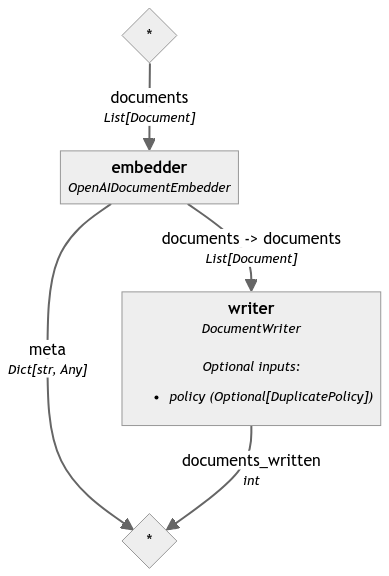

In [6]:
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", OpenAIDocumentEmbedder())
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")

In [7]:
indexing_pipeline.run({"embedder": {"documents": documents}})

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 187, 'total_tokens': 187}}},
 'writer': {'documents_written': 1}}

## Query Pipeline


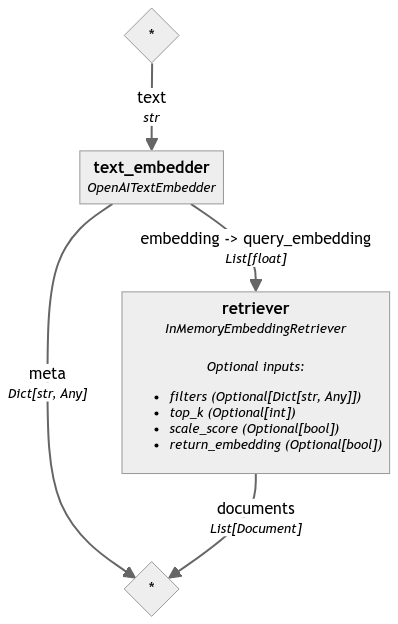

In [8]:
query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", OpenAITextEmbedder())
query_pipeline.add_component(
    "retriever", InMemoryEmbeddingRetriever(document_store=document_store)
)
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

## Execute Query Pipeline

In [9]:
query = input("Enter your query here: ")
result = query_pipeline.run({"text_embedder": {"text": query}})

In [10]:
result["retriever"]["documents"][0]

Document(id=817819f7b3a47a78c671d5b996a7033d8ed1f250b6e30a6cb57eb74539d06021, content: 'Title: Yaki Udon
Making Instructions: Boil some water in a large saucepan. Add 250ml cold water and ...', score: 0.7292987204503661)